In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as pd
import pandas as pd
import cv2
import pydicom
import scipy

from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib import pyplot as plt
from utils.mask_functions import *
from glob import glob
from PIL import Image
from scipy.sparse import load_npz
from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook

import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.utils import Sequence
from keras.preprocessing.image import load_img
from keras.models import Model, model_from_json
from keras.layers import Input, ReLU, LeakyReLU, core, Dropout, BatchNormalization, Concatenate, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# Restrict to single GPU
os.environ["CUDA_VISIBLE_DEVICES"]='0'

### Parse Data - Create Annotations

In [3]:
train_path = './siim/dicom-images-train/*/*/*.dcm'
mask_path = './siim/train-rle.csv'
images_to_ram = True # Low or high memory usage
img_height = 512
img_width = 512
n_channels = 3
batch_size = 8
epochs = 500

In [4]:
def get_train_df(train_path=train_path, mask_path=mask_path, images_to_ram=False, mask_img=False):
    rles_df = pd.read_csv(mask_path)
    rles_df.columns = ['ImageId', 'EncodedPixels']
        
    metadata_list = []
    train_fps = glob(train_path)

    if images_to_ram is True:
        img_dict = {}
    for i, fp in tqdm_notebook(enumerate(train_fps)):
        metadata = {}
        dcm = pydicom.dcmread(fp)
        metadata['ImageId'] = dcm.SOPInstanceUID
        metadata['FilePath'] = fp
        
        encoded_pixels_list = rles_df[rles_df['ImageId']==dcm.SOPInstanceUID]['EncodedPixels'].values
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        metadata['Pneumothorax'] = pneumothorax
        
        if images_to_ram is True:
            metadata['PixelArray'] = dcm.pixel_array
            if mask_img is True:
                if pneumothorax is True:
                    metadata['EncodedPixels'] = load_npz('siim/mask/'+dcm.SOPInstanceUID+'.npz').todense().astype('uint8')
                else:
                    metadata['EncodedPixels'] = np.zeros((1024, 1024))
                
        metadata_list.append(metadata)

    return pd.DataFrame(metadata_list)

In [5]:
df = get_train_df(train_path, mask_path, images_to_ram)

In [6]:
df.head()

,ImageId,FilePath,Pneumothorax,PixelArray
0,1.2.276.0.7230010.3.1.4.8323329.31935.15178751...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[1, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,..."
1,1.2.276.0.7230010.3.1.4.8323329.4297.151787518...,./siim/dicom-images-train/1.2.276.0.7230010.3....,True,"[[1, 0, 1, 0, 0, 3, 0, 0, 2, 1, 1, 0, 0, 0, 0,..."
2,1.2.276.0.7230010.3.1.4.8323329.12953.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,..."
3,1.2.276.0.7230010.3.1.4.8323329.12901.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[86, 87, 88, 88, 88, 88, 87, 86, 86, 86, 86, ..."
4,1.2.276.0.7230010.3.1.4.8323329.12036.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[153, 139, 123, 107, 94, 84, 75, 65, 57, 52, ..."


### Split and Balance the Data

In [7]:
# Imbalance between Pos and Neg classifications:
len(df[df.Pneumothorax == True]), len(df[df.Pneumothorax == False])

(2379, 8296)

In [8]:
train_df, val_df = train_test_split(df, stratify=df.Pneumothorax, test_size=0.2, random_state=88)

img_height = 1024
img_width = 1024
batch_size = 16

In [17]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_frame,
                 batch_size=4,
                 img_height=512,
                 img_width=512,
                 n_channels=3,
                 augmentations=None,
                 train=True,
                 shuffle=True):
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.n_channels = n_channels
        self.augment = augmentations
        self.train = train
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        'Batches per epoch'
        return int(np.ceil(len(self.data_frame) / self.batch_size))
    
    def on_epoch_end(self):
        'Update indexes when epoch ends'
        self.indexes = np.arange(len(self.data_frame))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        'Get one batch'
        batch_indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.data_frame))]
        
        if self.train is False:
            batch_x = self.data_generation(batch_indexes)
            
            if self.augment is None:
                return np.array(batch_x)/255
            else:
                return np.stack([self.augment(image=x)['image'] for x in batch_x], axis=0)
        
        batch_x, batch_y = self.data_generation(batch_indexes)
        
        if self.augment is None:
            return np.array(batch_x)/255, np.array(batch_y)
        else:
            return np.stack([self.augment(image=x)['image'] for x in batch_x], axis=0), np.array(batch_y)
        
    def data_generation(self, batch_indexes):
        if 'PixelArray' in self.data_frame.columns:
            X = [cv2.resize(img, (self.img_height, self.img_width)) for img in self.data_frame.iloc[batch_indexes]['PixelArray']]
        else:   
            fps = self.data_frame.iloc[batch_indexes].FilePath
            X = np.empty((len(fps), self.img_height, self.img_width))
            for i, fp in enumerate(fps):
                dcm = pydicom.dcmread(fp)
                X[i] = cv2.resize(dcm.pixel_array, (self.img_height, self.img_width))
        # Gray img to rgb
        X = np.stack([X, X, X], axis=3)
        
        if self.train is False:
            return np.uint8(X)

        Y = pd.concat([np.invert(self.data_frame.iloc[batch_indexes]['Pneumothorax'])+0,
                      self.data_frame.iloc[batch_indexes]['Pneumothorax']+0],
                      axis=1) 
        
        return np.uint8(X), np.uint8(Y)

In [18]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, GaussNoise, CenterCrop,
    IAAAdditiveGaussianNoise, GaussNoise, RandomSizedCrop, Normalize
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightness(p=0.5),
    ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.5
    ),
    RandomSizedCrop(min_max_height=(int(0.9*img_height), img_height), height=img_height, width=img_width, p=0.5),
    CLAHE(),
    ToFloat()
], p=1)


AUGMENTATIONS_TEST = Compose([
    CLAHE(),
    ToFloat()
], p=1)

# Add Gamma correction to test
#from imgaug import augmenters as iaa
#seq = iaa.Sequential([iaa.GammaContrast(1.2)])

### Check Augmentations

In [7]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()
    
def plot_pixel_array_overlay(data, label, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.imshow(label, alpha=.3)
    plt.show()
    
def plot_grid(imgs, grid_width, grid_height):
    max_imgs = grid_width*grid_height
    plt.clf()
    fig, axes = plt.subplots(grid_height, grid_width, figsize=(16, 12))
    
    for i, img in zip(range(max_imgs), imgs):
        ax = axes[int(i/grid_width), i%grid_width]
        ax.imshow(img, cmap='bone')
        ax.axis('off')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

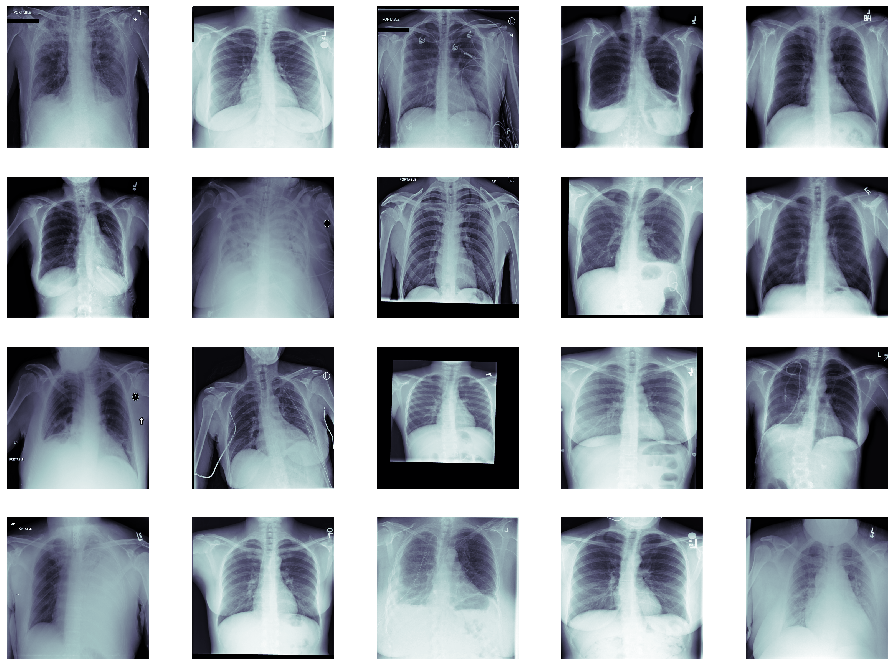

(0.0, 1.0, (20, 512, 512, 3), (512, 512, 3), (20, 2))

In [105]:
a = DataGenerator(data_frame=train_df, batch_size=20, shuffle=False,
                 img_height=img_height, img_width=img_width, n_channels=n_channels)
imgs, masks = a.__getitem__(0)
plot_grid(imgs[:,:,:,0], 5, 4)
imgs[0].min(), imgs[0].max(), imgs.shape, imgs[0].shape, masks.shape

<Figure size 432x288 with 0 Axes>

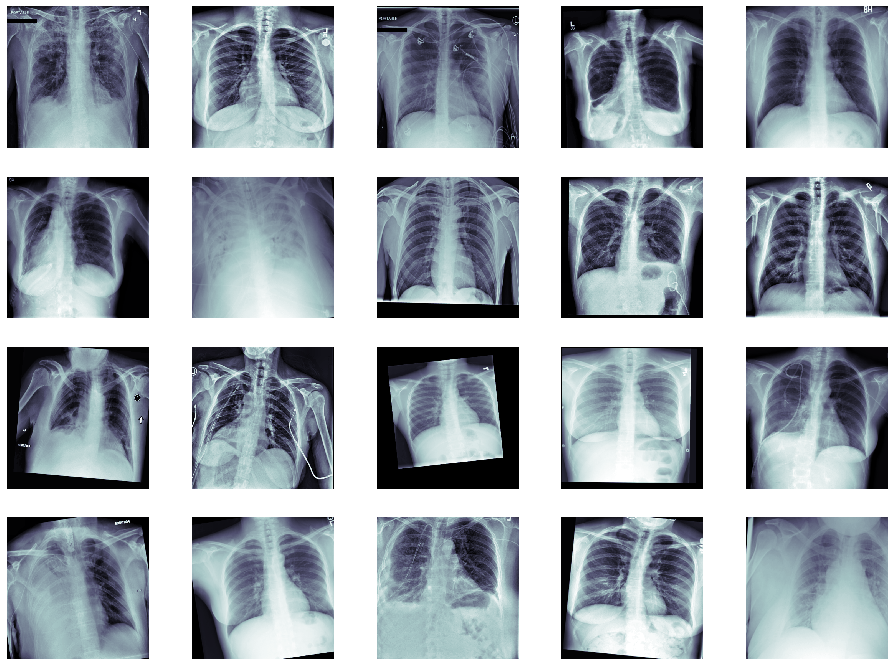

(0.007843138, 0.99607843, (20, 512, 512, 3), (512, 512, 3))

In [106]:
# Augmented
b = DataGenerator(data_frame=train_df, batch_size=20, augmentations=AUGMENTATIONS_TRAIN, shuffle=False,
                 img_height=img_height, img_width=img_width, n_channels=n_channels)
imgs, masks = b.__getitem__(0)
plot_grid(imgs[:,:,:,0], 5, 4)
imgs[0].min(), imgs[0].max(), imgs.shape, imgs[0].shape

<Figure size 432x288 with 0 Axes>

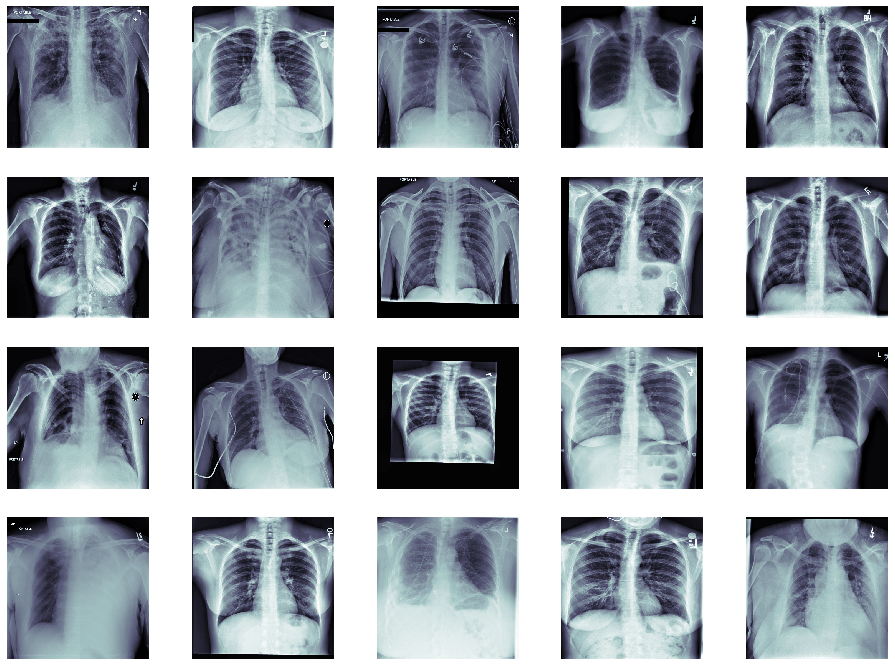

(0.007843138, 1.0, (20, 512, 512, 3), (512, 512, 3))

In [102]:
# Test Time Augmentations
b = DataGenerator(data_frame=train_df, batch_size=20, augmentations=AUGMENTATIONS_TEST, shuffle=False,
                 img_height=img_height, img_width=img_width, n_channels=n_channels)
imgs, masks = b.__getitem__(0)
plot_grid(imgs[:,:,:,0], 5, 4)
imgs[0].min(), imgs[0].max(), imgs.shape, imgs[0].shape

### Balance Data

### Data Loader with Augmentations

### Finetune Pretrained Networks

In [8]:
def get_resnet50(img_height=img_height, img_width=img_width, n_channels=n_channels, tail_block=False):
    inputs = Input(shape=(img_height, img_width, n_channels))
    
    base = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    
    for layer in base.layers:
        layer.trainable = True
    
    if tail_block is False:
        outputs = GlobalAveragePooling2D()(base.output)
    else:
        outputs = tail(base.output)
    
    outputs = Dense(2, activation='softmax')(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def get_resnext50(img_height=img_height, img_width=img_width, n_channels=n_channels, tail_block=False):
    inputs = Input(shape=(img_height, img_width, n_channels))
    
    base = ResNeXt50(include_top=False, weights='imagenet', input_tensor=inputs,
                    backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)
    
    for layer in base.layers:
        layer.trainable = True
    
    if tail_block is False:
        outputs = GlobalAveragePooling2D()(base.output)
    else:
        outputs = tail(base.output)
        
    outputs = Dense(2, activation='softmax')(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def tail(inputs, d=0.5):
    ap = GlobalAveragePooling2D()(inputs)
    mp = GlobalMaxPooling2D()(inputs)
    conc = Concatenate(axis=1)([ap, mp])
    out = BatchNormalization()(conc)
    out = Dropout(rate=d)(out)
    
    out = Dense(1024, activation='relu')(out)
    out = BatchNormalization()(out)
    out = Dropout(rate=d)(out)
    
    return out 

In [9]:
K.clear_session()
model_name = 'resnet50_w_tail'
try:
    os.mkdir('./save/'+model_name)
except Exception:
    pass
model = get_resnet50(tail_block=True)
model.summary()

W0828 01:11:01.424733 139869671532288 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0828 01:11:01.428623 139869671532288 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 01:11:01.457818 139869671532288 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 01:11:01.459144 139869671532288 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W082

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [86]:
adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint('./save/'+model_name+'/'+model_name+'_BEST.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(patience=25)
with open('./save/'+model_name+'/'+model_name+'_ARCHITECTURE.json', 'w') as f:
    f.write(model.to_json())

In [87]:
training_generator = DataGenerator(data_frame=train_df,
                                   img_height=img_height,
                                   img_width=img_width,
                                   n_channels=n_channels,
                                   batch_size=batch_size,
                                   augmentations=AUGMENTATIONS_TRAIN)
validation_generator = DataGenerator(data_frame=val_df,
                                     img_height=img_height,
                                     img_width=img_width,
                                     n_channels=n_channels,
                                     batch_size=batch_size,
                                     augmentations=AUGMENTATIONS_TEST)
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              use_multiprocessing=False,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[early_stopping, checkpointer])

Epoch 1/500
1068/1068 [==============================] - 281s 263ms/step - loss: 0.8920 - acc: 0.6354 - val_loss: 1.1371 - val_acc: 0.4768

Epoch 00001: val_acc improved from -inf to 0.47681, saving model to ./save/resnet50_w_tail/resnet50_w_tail_BEST.h5
Epoch 2/500
1068/1068 [==============================] - 269s 251ms/step - loss: 0.5761 - acc: 0.7443 - val_loss: 0.4592 - val_acc: 0.8150

Epoch 00002: val_acc improved from 0.47681 to 0.81499, saving model to ./save/resnet50_w_tail/resnet50_w_tail_BEST.h5
Epoch 3/500
1068/1068 [==============================] - 269s 252ms/step - loss: 0.4939 - acc: 0.7845 - val_loss: 0.5097 - val_acc: 0.7691

Epoch 00003: val_acc did not improve from 0.81499
Epoch 4/500
1068/1068 [==============================] - 269s 252ms/step - loss: 0.4475 - acc: 0.8023 - val_loss: 0.4126 - val_acc: 0.8422

Epoch 00004: val_acc improved from 0.81499 to 0.84215, saving model to ./save/resnet50_w_tail/resnet50_w_tail_BEST.h5
Epoch 5/500
1068/1068 [================

In [89]:
model.save_weights('./save/'+model_name+'/'+model_name+'_LAST.h5', overwrite=True)

### Sanity Check on Validation

In [10]:
# with open('./save/'+model_name+'/'+model_name+'_ARCHITECTURE.json', 'r') as f:
#     model = model_from_json(f.read())
model.load_weights('./save/'+model_name+'/'+model_name+'_BEST.h5')

In [93]:
validation_generator = DataGenerator(data_frame=val_df,
                                     img_height=img_height,
                                     img_width=img_width,
                                     n_channels=n_channels,
                                     batch_size=batch_size,
                                     augmentations=AUGMENTATIONS_TEST,
                                     shuffle=False)
preds_val = model.predict_generator(validation_generator)

In [94]:
accuracy = np.mean(np.equal(np.argmax(preds_val, axis=-1), np.array(val_df['Pneumothorax']+0)))
print(accuracy)

0.8880562060889929


In [95]:
K.clear_session()

### Plot Accuracy and Loss

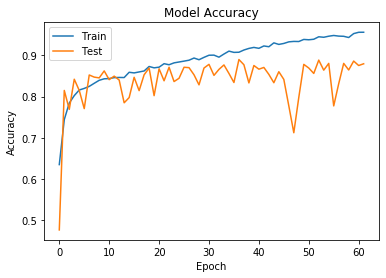

In [96]:
# Acc
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

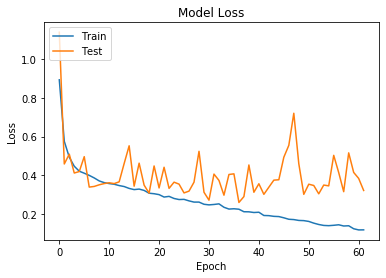

In [97]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Test

In [11]:
test_path = './siim/dicom-images-test/*/*/*.dcm'

In [12]:
def get_test_df(test_path=test_path):
    metadata_list = []
    test_fps = glob(test_path)

    for i, fp in tqdm_notebook(enumerate(test_fps)):
        metadata = {}
        dcm = pydicom.dcmread(fp)
        metadata['ImageId'] = dcm.SOPInstanceUID
        metadata['FilePath'] = fp
        metadata['PixelArray'] = dcm.pixel_array    
        metadata_list.append(metadata)

    return pd.DataFrame(metadata_list)

In [13]:
test_df = get_test_df(test_path)

In [19]:
#model.load_weights('./save/'+model_name+'/'+model_name+'_BEST.h5')
test_generator = DataGenerator(data_frame=test_df,
                               img_height=img_height,
                               img_width=img_width,
                               n_channels=n_channels,
                               batch_size=batch_size,
                               augmentations=AUGMENTATIONS_TEST,
                               train=False,
                               shuffle=False)
test_preds = model.predict_generator(test_generator)

In [38]:
is_pneumo = test_preds[:,1]
not_pneumo = test_preds[:,0]
len(test_preds)

1372

In [39]:
len(is_pneumo[prob_pneumo > 0.5]), len(is_pneumo[not_pneumo >= 0.5])

(271, 1101)

In [40]:
len(is_pneumo[is_pneumo > 0.55])

260

In [60]:
len(is_pneumo[is_pneumo > 0.95])

39

In [53]:
df = pd.read_csv('siim/sample_submission.csv')

In [57]:
def classifier_to_csv(filename, threshold):
    df = pd.read_csv('siim/sample_submission.csv')
    encoded_pixels = []
    n_pos = 0
    n_neg = 0
    for i in range(len(test_preds)):
        if test_preds[i,1] > threshold:
            encoded_pixels.append(1)
            n_pos += 1
        else:
            encoded_pixels.append(-1)
            n_neg += 1

    df['EncodedPixels'] = encoded_pixels
    df.to_csv(filename, columns=['ImageId', 'EncodedPixels'], index=False)
    
    print('Pos:', n_pos, 'Neg:', n_neg)

In [58]:
classifier_to_csv('classifier55.csv', 0.55)

Pos: 260 Neg: 1112


In [59]:
classifier_to_csv('classifier60.csv', 0.6)

Pos: 239 Neg: 1133


In [64]:
classifier_to_csv('classifier90.csv', 0.9)

Pos: 74 Neg: 1298


In [63]:
classifier_to_csv('classifier95.csv', 0.95)

Pos: 39 Neg: 1333
